In [2]:
import pandas as pd
import networkx as nx
import numpy as np

from itertools import product
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
bin_dims = (5, 3)

y_bins = np.linspace(0, 68, bin_dims[1] + 1)  
y_df = pd.DataFrame({"y_bin_start": y_bins[:-1], "y_bin_end": y_bins[1:]})

x_bins = np.linspace(0, 105, bin_dims[0] + 1)
x_df = pd.DataFrame({"x_bin_start": x_bins[:-1], "x_bin_end": x_bins[1:]})

segments_df = pd.DataFrame(
    list(product(
        zip(x_df["x_bin_start"], x_df["x_bin_end"]),
        zip(y_df["y_bin_start"], y_df["y_bin_end"])
    )),
    columns=["x_bins", "y_bins"]
)
segments_df["x_bin_start"], segments_df["x_bin_end"] = zip(*segments_df["x_bins"])
segments_df["y_bin_start"], segments_df["y_bin_end"] = zip(*segments_df["y_bins"])
segments_df = segments_df.drop(columns=["x_bins", "y_bins"])
segments_df['segment'] = segments_df.index + 1


In [4]:
# do passing and attacking graphs

df = pd.read_csv('../00_data/01_actions_data/actions_segmented_5x3.csv')

ball_movements = ['pass', 'cross', 'throw_in', 'goalkick', 'freeckick_crossed', 'freekick_short', 'goal_kick']
attack_moves = ['shot', 'shot_freekick', 'shot_penalty']
defensive_moves = ['interception', 'tackle', 'clearance', 'keeper_save', 'keeper_claim', 'keeper_punch', 'keeper_pick_up', 'keeper_sweeper', 'keeper_success']
graph_df = pd.DataFrame()

game_ids = df['game_id'].unique()

for game in tqdm(game_ids, desc="Games Progress"):
     teams = df[df['game_id'] == game]['team_id'].unique()
     for team in teams:
          team_df = df[(df['game_id'] == game) & (df['team_id'] == team)]
          acts = team_df[team_df['type_name'].isin(ball_movements) & (team_df['result_name'] == 'success')]
          
          G = nx.DiGraph()

          for _, row in acts.iterrows():
               player = row['start_segment']
               recipient = row['end_segment']

               if G.has_edge(player, recipient):
                    G[player][recipient]['weight'] += 1
               else:
                    G.add_edge(player, recipient, weight=1)
          
          for u, v in product(segments_df['segment'], segments_df['segment']):
               if not G.has_edge(u, v):
                    G.add_edge(u, v, weight=0)

          attack_actions = team_df[(team_df['type_name'].isin(attack_moves))]
          attack_G = nx.DiGraph()
          
          for _, row in attack_actions.iterrows():
               player = row['start_segment']
               recipient = row['end_segment']

               if attack_G.has_edge(player, recipient):
                    attack_G[player][recipient]['weight'] += 1
               else:
                    attack_G.add_edge(player, recipient, weight=1)

          for u, v in product(segments_df['segment'], segments_df['segment']):
               if not attack_G.has_edge(u, v):
                    attack_G.add_edge(u, v, weight=0)

          graph_df = pd.concat([graph_df, pd.DataFrame({'game_id':[game] , 'team': [team], 'ball_movements_graph': [G], 'attack_graph': [attack_G]})])

graph_df

Games Progress: 100%|██████████| 1826/1826 [00:39<00:00, 46.06it/s]


,game_id,team,ball_movements_graph,attack_graph
0,2500089,1659,"(11.0, 13.0, 10.0, 9.0, 6.0, 8.0, 1, 2, 3, 4, ...","(11.0, 13.0, 9.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10..."
0,2500089,1646,"(12.0, 9.0, 11.0, 14.0, 4.0, 7.0, 10.0, 15.0, ...","(5.0, 2.0, 3.0, 14.0, 11.0, 1, 4, 6, 7, 8, 9, ..."
0,2500090,1628,"(8.0, 7.0, 10.0, 11.0, 9.0, 6.0, 14.0, 12.0, 1...","(5.0, 2.0, 4.0, 14.0, 1, 3, 6, 7, 8, 9, 10, 11..."
0,2500090,1627,"(9.0, 11.0, 13.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(11.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13..."
0,2500091,1673,"(11.0, 9.0, 13.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(11.0, 9.0, 10.0, 1, 2, 3, 4, 5, 6, 7, 8, 12, ..."
...,...,...,...,...
0,2565549,692,"(6.0, 9.0, 13.0, 11.0, 8.0, 10.0, 1, 2, 3, 4, ...","(9.0, 11.0, 13.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10..."
0,2565556,674,"(8.0, 12.0, 9.0, 11.0, 10.0, 4.0, 5.0, 13.0, 6...","(2.0, 6.0, 3.0, 1.0, 12.0, 14.0, 15.0, 11.0, 1..."
0,2565556,714,"(8.0, 13.0, 11.0, 9.0, 6.0, 10.0, 1, 2, 3, 4, ...","(11.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13..."
0,2565557,696,"(8.0, 11.0, 4.0, 10.0, 12.0, 7.0, 15.0, 9.0, 1...","(3.0, 2.0, 11.0, 14.0, 15.0, 1, 4, 5, 6, 7, 8,..."


In [5]:
graph_df['ball_movements_graph'] = graph_df['ball_movements_graph'].apply(lambda x: nx.adjacency_matrix(x).todense().mean())
graph_df['attack_graph'] = graph_df['attack_graph'].apply(lambda x: nx.adjacency_matrix(x).todense().mean())

graph_df

,game_id,team,ball_movements_graph,attack_graph
0,2500089,1659,1.546667,0.062222
0,2500089,1646,1.551111,0.040000
0,2500090,1628,2.324444,0.048889
0,2500090,1627,1.506667,0.026667
0,2500091,1673,1.555556,0.080000
...,...,...,...,...
0,2565549,692,1.791111,0.071111
0,2565556,674,1.768889,0.093333
0,2565556,714,1.924444,0.017778
0,2565557,696,1.213333,0.035556


In [6]:
df = pd.read_csv('../00_data/01_actions_data/matches.csv')
df2 = pd.read_csv('../00_data/00_statistical_data/17_18_processed.csv')

team_mapping = {
    'AFC Bournemouth': 'Bournemouth',
    'Amiens SC': 'Amiens',
    'Angers SCO': 'Angers',
    'Arsenal': 'Arsenal',
    'Atalanta': 'Atalanta',
    'Athletic Club': 'Ath Bilbao',
    'Atlético Madrid': 'Ath Madrid',
    'Augsburg': 'Augsburg',
    'Barcelona': 'Barcelona',
    'Bayer Leverkusen': 'Leverkusen',
    'Bayern München': 'Bayern Munich',
    'Benevento': 'Benevento',
    'Bologna': 'Bologna',
    'Bordeaux': 'Bordeaux',
    'Borussia Dortmund': 'Dortmund',
    "Borussia M'gladbach": "M'gladbach",
    'Brighton & Hove Albion': 'Brighton',
    'Burnley': 'Burnley',
    'Caen': 'Caen',
    'Cagliari': 'Cagliari',
    'Celta de Vigo': 'Celta',
    'Chelsea': 'Chelsea',
    'Chievo': 'Chievo',
    'Crotone': 'Crotone',
    'Crystal Palace': 'Crystal Palace',
    'Deportivo Alavés': 'Alaves',
    'Deportivo La Coruña': 'La Coruna',
    'Dijon': 'Dijon',
    'Eibar': 'Eibar',
    'Eintracht Frankfurt': 'Ein Frankfurt',
    'Espanyol': 'Espanol',
    'Everton': 'Everton',
    'Fiorentina': 'Fiorentina',
    'Freiburg': 'Freiburg',
    'Genoa': 'Genoa',
    'Getafe': 'Getafe',
    'Girona': 'Girona',
    'Guingamp': 'Guingamp',
    'Hamburger SV': 'Hamburg',
    'Hannover 96': 'Hannover',
    'Hellas Verona': 'Verona',
    'Hertha BSC': 'Hertha',
    'Hoffenheim': 'Hoffenheim',
    'Huddersfield Town': 'Huddersfield',
    'Internazionale': 'Inter',
    'Juventus': 'Juventus',
    'Köln': 'FC Koln',
    'Las Palmas': 'Las Palmas',
    'Lazio': 'Lazio',
    'Leganés': 'Leganes',
    'Leicester City': 'Leicester',
    'Levante': 'Levante',
    'Lille': 'Lille',
    'Liverpool': 'Liverpool',
    'Mainz 05': 'Mainz',
    'Manchester City': 'Man City',
    'Manchester United': 'Man United',
    'Metz': 'Metz',
    'Milan': 'Milan',
    'Monaco': 'Monaco',
    'Montpellier': 'Montpellier',
    'Málaga': 'Malaga',
    'Nantes': 'Nantes',
    'Napoli': 'Napoli',
    'Newcastle United': 'Newcastle',
    'Nice': 'Nice',
    'Olympique Lyonnais': 'Lyon',
    'Olympique Marseille': 'Marseille',
    'PSG': 'Paris SG',
    'RB Leipzig': 'RB Leipzig',
    'Real Betis': 'Betis',
    'Real Madrid': 'Real Madrid',
    'Real Sociedad': 'Sociedad',
    'Rennes': 'Rennes',
    'Roma': 'Roma',
    'SPAL': 'Spal',
    'Saint-Étienne': 'St Etienne',
    'Sampdoria': 'Sampdoria',
    'Sassuolo': 'Sassuolo',
    'Schalke 04': 'Schalke 04',
    'Sevilla': 'Sevilla',
    'Southampton': 'Southampton',
    'Stoke City': 'Stoke',
    'Strasbourg': 'Strasbourg',
    'Stuttgart': 'Stuttgart',
    'Swansea City': 'Swansea',
    'Torino': 'Torino',
    'Tottenham Hotspur': 'Tottenham',
    'Toulouse': 'Toulouse',
    'Troyes': 'Troyes',
    'Udinese': 'Udinese',
    'Valencia': 'Valencia',
    'Villarreal': 'Villarreal',
    'Watford': 'Watford',
    'Werder Bremen': 'Werder Bremen',
    'West Bromwich Albion': 'West Brom',
    'West Ham United': 'West Ham',
    'Wolfsburg': 'Wolfsburg'
}

df2['HomeTeam'] = df2['HomeTeam'].map(team_mapping)
df2['AwayTeam'] = df2['AwayTeam'].map(team_mapping)

df3 = pd.merge(df, df2, how='inner', left_on=['date', 'home_team', 'away_team'], right_on=['Date', 'HomeTeam', 'AwayTeam'])

df3

,date,game_id,home_team,home_team_id,away_team,away_team_id,home_goals,away_goals,result,Date,...,AwayTeam_FullTimeGoals_mean,AwayTeam_Shots_mean,AwayTeam_ShotsOnTarget_mean,AwayTeam_Corners_mean,AwayTeam_Fouls_mean,AwayTeam_YellowCards_mean,AwayTeam_points,HomeTeamRate,AwayTeamRate,season
0,2017-08-04,2500691,Monaco,3780,Toulouse,19830,3,2,H,2017-08-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
1,2017-08-05,2500690,Metz,3777,Guingamp,3785,1,3,A,2017-08-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2,2017-08-05,2500695,Troyes,3774,Rennes,3795,1,1,D,2017-08-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
3,2017-08-05,2500692,Montpellier,3783,Caen,3787,1,0,H,2017-08-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4,2017-08-06,2500687,Lille,3770,Nantes,3776,3,0,H,2017-08-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,2018-05-20,2576329,Cagliari,3173,Atalanta,3172,1,0,H,2018-05-20,...,1.6,16.8,5.0,5.4,14.6,3.2,2.2,1.105263,1.421053,2018
652,2018-05-20,2576330,Chievo,3165,Benevento,3219,1,0,H,2018-05-20,...,1.0,13.0,4.6,4.2,14.0,2.2,1.4,1.421053,0.210526,2018
653,2018-05-20,2576331,Udinese,3166,Bologna,3163,1,0,H,2018-05-20,...,0.6,12.6,4.0,5.4,13.0,1.6,0.2,1.052632,0.894737,2018
654,2018-05-20,2576332,Napoli,3197,Crotone,3187,2,1,H,2018-05-20,...,1.6,10.4,4.4,4.4,14.4,2.4,1.6,2.368421,0.578947,2018


In [7]:
matches = pd.merge(df3, graph_df, left_on=['game_id', 'home_team_id'], right_on=['game_id', 'team'], how='left')
matches.rename(columns={'ball_movements_graph': 'home_team_pass_graph', 'attack_graph': 'home_team_attack_graph'}, inplace=True)

matches = pd.merge(matches, graph_df, left_on=['game_id', 'away_team_id'], right_on=['game_id', 'team'], how='left')
matches.rename(columns={'ball_movements_graph': 'away_team_pass_graph', 'attack_graph': 'away_team_attack_graph'}, inplace=True)

matches.sort_values(by='date', ascending=True, inplace=True)

matches['home_team_prev_mv_graph_1'] = matches.groupby('home_team')['home_team_pass_graph'].shift(1)
matches['away_team_prev_mv_graph_1'] = matches.groupby('away_team')['away_team_pass_graph'].shift(1)

matches['home_team_prev_attack_graph_1'] = matches.groupby('home_team')['home_team_attack_graph'].shift(1)
matches['away_team_prev_attack_graph_1'] = matches.groupby('away_team')['away_team_attack_graph'].shift(1)

matches['home_team_prev_mv_graph_2'] = matches.groupby('home_team')['home_team_pass_graph'].shift(2)
matches['away_team_prev_mv_graph_2'] = matches.groupby('away_team')['away_team_pass_graph'].shift(2)

matches['home_team_prev_attack_graph_2'] = matches.groupby('home_team')['home_team_attack_graph'].shift(2)
matches['away_team_prev_attack_graph_2'] = matches.groupby('away_team')['away_team_attack_graph'].shift(2)

matches['home_team_prev_mv_graph_3'] = matches.groupby('home_team')['home_team_pass_graph'].shift(3)
matches['away_team_prev_mv_graph_3'] = matches.groupby('away_team')['away_team_pass_graph'].shift(3)

matches['home_team_prev_attack_graph_3'] = matches.groupby('home_team')['home_team_attack_graph'].shift(3)
matches['away_team_prev_attack_graph_3'] = matches.groupby('away_team')['away_team_attack_graph'].shift(3)

matches = matches.dropna()
matches

,date,game_id,home_team,home_team_id,away_team,away_team_id,home_goals,away_goals,result,Date,...,home_team_prev_attack_graph_1,away_team_prev_attack_graph_1,home_team_prev_mv_graph_2,away_team_prev_mv_graph_2,home_team_prev_attack_graph_2,away_team_prev_attack_graph_2,home_team_prev_mv_graph_3,away_team_prev_mv_graph_3,home_team_prev_attack_graph_3,away_team_prev_attack_graph_3
96,2017-09-22,2500748,Lille,3776,Monaco,19830,0,4,A,2017-09-22,...,0.075556,0.040000,0.977778,1.982222,0.048889,0.097778,1.155556,1.684444,0.035556,0.066667
98,2017-09-23,2576014,Juventus,3185,Torino,3159,4,0,H,2017-09-23,...,0.040000,0.057778,1.568889,2.208889,0.062222,0.080000,1.617778,2.146667,0.022222,0.035556
118,2017-09-30,2576022,Genoa,3166,Bologna,3193,0,1,A,2017-09-30,...,0.062222,0.040000,2.324444,1.951111,0.080000,0.062222,1.835556,1.706667,0.035556,0.048889
129,2017-10-14,2500770,Lille,3776,Troyes,3795,2,2,D,2017-10-14,...,0.048889,0.035556,2.266667,1.688889,0.075556,0.022222,0.977778,1.168889,0.048889,0.044444
136,2017-10-15,2500766,Bordeaux,3772,Nantes,3770,1,1,D,2017-10-15,...,0.097778,0.048889,2.151111,2.000000,0.057778,0.048889,2.017778,2.533333,0.044444,0.035556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,2018-05-20,2576336,Sassuolo,3158,Roma,3315,0,1,A,2018-05-20,...,0.071111,0.053333,1.213333,1.720000,0.035556,0.044444,1.346667,1.057778,0.066667,0.022222
651,2018-05-20,2576329,Cagliari,3173,Atalanta,3172,1,0,H,2018-05-20,...,0.040000,0.080000,1.560000,1.817778,0.040000,0.053333,1.911111,2.084444,0.053333,0.057778
652,2018-05-20,2576330,Chievo,3165,Benevento,3219,1,0,H,2018-05-20,...,0.048889,0.093333,1.346667,2.355556,0.026667,0.044444,1.355556,0.946667,0.048889,0.026667
653,2018-05-20,2576331,Udinese,3166,Bologna,3163,1,0,H,2018-05-20,...,0.066667,0.057778,2.640000,1.471111,0.062222,0.026667,1.582222,1.693333,0.053333,0.062222


# MLP

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

X = matches[[
    'home_team_prev_mv_graph_1', 'away_team_prev_mv_graph_1',
    'home_team_prev_mv_graph_2', 'away_team_prev_mv_graph_2',
    'home_team_prev_mv_graph_3', 'away_team_prev_mv_graph_3',
    'home_team_prev_attack_graph_1', 'away_team_prev_attack_graph_1',
    'home_team_prev_attack_graph_2', 'away_team_prev_attack_graph_2',
    'home_team_prev_attack_graph_3', 'away_team_prev_attack_graph_3',
    'HomeTeam_FullTimeGoals_mean', 'AwayTeam_FullTimeGoals_mean',
    'HomeTeam_Shots_mean', 'AwayTeam_Shots_mean',
    'HomeTeam_ShotsOnTarget_mean', 'AwayTeam_ShotsOnTarget_mean',
    'HomeTeam_Fouls_mean', 'AwayTeam_Fouls_mean',
    'HomeTeam_Corners_mean', 'AwayTeam_Corners_mean',
    'HomeTeam_points', 'AwayTeam_points',
    'HomeTeamRate', 'AwayTeamRate'
]]

y = matches['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32, 16, 8),
    activation='relu',                 
    solver='adam',                     
    alpha=0.001,                       
    batch_size=32,                     
    learning_rate='adaptive',          
    learning_rate_init=0.001,          
    max_iter=500,                      
    validation_fraction=0.15,          
    n_iter_no_change=15,               
    random_state=42,                   
)

mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.001, batch_size=32,
              hidden_layer_sizes=(128, 64, 32, 16, 8), learning_rate='adaptive',
              max_iter=500, n_iter_no_change=15, random_state=42,
              validation_fraction=0.15)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = mlp.predict(X_test)

print(classification_report(y_test, y_test_pred, target_names=['Loss', 'Draw', 'Win']))

              precision    recall  f1-score   support

        Loss       0.55      0.55      0.55        33
        Draw       0.30      0.35      0.32        23
         Win       0.65      0.57      0.61        35

    accuracy                           0.51        91
   macro avg       0.50      0.49      0.49        91
weighted avg       0.52      0.51      0.51        91



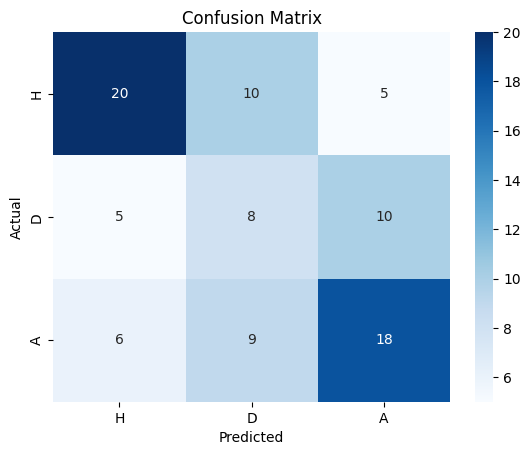

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)[::-1, ::-1]
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['H', 'D', 'A'], yticklabels=['H', 'D', 'A'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()